`computer vision`                         
`Kushal Jain 2019111001`
# Assignment 2 Report
## 1.1 Thought Experiments
 
### 1. Describe how optical flow could be used to create slow motion video.
Video frame rate determines the quality of motion in the video. A high frame rate video can slowed and played at lower rfame rates to make slow-motion videos. Low-frame rate videos can be converted into high frame rate by interpolation. Interpolation of unknown frames in between known frames can be done using optical flow. As optical flow describes the motion of objects in the frames, we can use this information to interpolate between frames. 

 
### 2. watch “Bullet Time” and explain briefly how optical flow is used. 

 Optical flow is used to interpolate the frmaes missing between the cameras. The cameras on the bullet time rig are fired sequentially, or all at the same time, depending on the desired effect. Single frames from each camera are then arranged and displayed consecutively to produce an orbiting viewpoint of an action frozen in time or as hyper-slow-motion. As there were a lot of frames missing in between two consecutive camera shots. optical flow was used to add extra frames to slow down the action further and improve the fluidity of the movement.
 
 
### 3. how optical flow is used to create this “painterly effect”

Optical flow gives us set of vectors that tells us the x and y shifts of a set of similarly lit pixels. This can help us generate a paint stroke for every pixel of the image, and then we can transform that paint stroke to the next image and to the next image after that, and so on.  


### 4.1  rotating about its axis in 3D under constant illumination 

A rotating Lambertian sphere with a static light source
produces a static image and hence the brightness remains the same. So  , the brighntness constancy assumption holds true. 
### 4.2  rotating about its axis in 3D under moving illumination
a stationary sphere with a moving light source produces drifting intensities, which violates brighness constancy assumptions made in optical flow estimation. As the se of pixels with constant brightness keep moving, there is optical flow that is detected. This is one of the main drawbacks of optical flow estimation using traditional methods. 

## 1.2 Concept Review

### 1. assumptions made in optical flow estimation.
- The first assumption we make is that pixels retain the same brightness or intensity between frames. Only their positions change due to the motion of the camera, observer, or objects in the scene. hence, we do not consider changes in lighting, for example. This is the brightness constancy assumption.
- The second assumption is the spatial coherence assumption. We assume that neighbouring pixels of a given pixel have the same flow or shift as the pixel under consideration. This means that groups of pixels for together in a similar motion, and not just individual pixels. This is done to avoid making the problem under-constrained, giving us enough equations to solve for unknowns.


### 2. Formalize the objective function of the classical optical flow problem.

The objective function is :   
$$I(x , y , t) = I(x + u, y + v, t + 1)$$    
$ where, (u , v)$  = flow for that pixel and   
$ (x , y) = $ location of the pixel 

Assuming brightness to be constant, we apply taylor expansion as the change in $(x,y)$ is small.   

$$ \nabla I [ U V ] ^T + I_t = 0 $$  
here  $$ \nabla I = [I_x I_y] $$         (Spatial term as it involves derivative at a point )  
and, $$ I_t = I(t+1) - I(t) $$           (Data term as it is difference in data at two points )


Assuming spatial coherence  (flow is same around the pixel) for $5X5$ window,
we have :  
$$ Ad = b$$
where,
$A = \begin{bmatrix}
  I_{x_1}  I_{y_1}\\I_{x_2}  I_{y_2}\\ \vdots \\ I_{x_{25}} I_{y_{25}} \end{bmatrix} ,
d = \begin{bmatrix}
  U \\ V \\
\end{bmatrix},b = \begin{bmatrix}
  I_{t_1}\\
  I_{t_2} \\
  \vdots \\
  I_{t_{25}} 
\end{bmatrix}$


After multiplying by $A^T$ on both sides we have the Lukas Kanade equation : 
 $$ (A^T A )d = A^T b$$


### 3. In optimization, why is the first-order Taylor series approximation done?
The first-order Taylor series approximation is done to simplify the equation,making it in terms of the derivative of the image and the flow, as separate terms. If this simplification was not done, it would not be possible to estimate the flow, since the original equation consists of a function of the flow: 
$I(x + u, y + v, t + 1)$ rather than the flow itself: $(u, v)$ .
The Taylor approximation results in us being able to estimate the flow directly, since
we obtain a linear equation which we can solve to obtain the flow. Further, its terms
are easy to compute: for example, the derivatives of the first image and the
difference between the two images. 
The objective function before taylo expansion is : 

$$I(x , y , t) = I(x + u, y + v, t + 1)$$      
where, 
$(u , v) $  = flow for that pixel and   
$ (x , y) = $ location of the pixel 

After taylor expansion :    

$$ \nabla I [ U V ] ^T + I_t = 0$$  
here  
$ \nabla I = [I_x I_y]$           
and, 
$ I_t = I(t+1) - I(t) $.         

### 4. Geometrically show how the optical flow constraint equation is ill-posed.

Geometrically, the objective function obtained after the Taylor series approximation fails because motion perpendicular to the gradient at any point cannot be captured in the equation.
if 
$ \nabla I [ u^{'} v^{'} ] ^T + I_t = 0  $ ,this means that 
$ [ u^{'} v^{'}] ^T $ is perpendicular to the grradient at a point. so for these 
$u,v$  $ \nabla I [ u v ] ^T + I_t = 0  $ is satified for 
$ [ u v ]$ and also 
$[ u + u^{'} v + v^{'} ] $


## 2 Single-Scale Lucas-Kanade Optical Flow
### 2.1 Keypoint Selection: Selecting Pixels to Track

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy import linalg as LA
# Sobel x-axis kernel
SOBEL_X = np.array((
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]), dtype="int32")

# Sobel y-axis kernel
SOBEL_Y = np.array((
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]), dtype="int32")

# Gaussian kernel
GAUSS = np.array((
    [1/16, 2/16, 1/16],
    [2/16, 4/16, 2/16],
    [1/16, 2/16, 1/16]), dtype="float64")


def convolve(img, kernel):
    """Performs a naive convolution."""
    if kernel.shape[0] % 2 != 1 or kernel.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")

    img_height = img.shape[0]
    img_width = img.shape[1]
    pad_height = kernel.shape[0] // 2
    pad_width = kernel.shape[1] // 2
    # Allocate result image.
    pad = ((pad_height, pad_height), (pad_height, pad_width))
    g = np.empty(img.shape, dtype=np.float64)
    img = np.pad(img, pad, mode='constant', constant_values=0)
    # Do convolution
    for i in np.arange(pad_height, img_height+pad_height):
        for j in np.arange(pad_width, img_width+pad_width):
            roi = img[i - pad_height:i + pad_height +
                      1, j - pad_width:j + pad_width + 1]
            g[i - pad_height, j - pad_width] = (roi*kernel).sum()

    if (g.dtype == np.float64):
        kernel = kernel / 255.0
        kernel = (kernel*255).astype(np.uint8)
    else:
        g = g + abs(np.amin(g))
        g = g / np.amax(g)
        g = (g*255.0)

    return g


def mark_points(MaxR,img0) : 
    img1 = img0.copy()
    
    for i in range(len(MaxR)):
        
        center_coordinatesR = MaxR[i]
        
        img1 = cv2.circle(img1, center_coordinatesR, radius=4, color= (255, 0, 0), thickness= 1)
    
    return img1



### Harris Detector Implementation

In [ ]:
def harris(img, threshold):

    img_cpy = img.copy()

    # Grayscale
    img1_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    dx = convolve(img1_gray, SOBEL_X)
    dy = convolve(img1_gray, SOBEL_Y)

    dx2 = np.square(dx)
    dy2 = np.square(dy)
    dxdy = dx*dy

    g_dx2 = convolve(dx2, GAUSS)
    g_dy2 = convolve(dy2, GAUSS)
    g_dxdy = convolve(dxdy, GAUSS)

    harris = g_dx2*g_dy2 - np.square(g_dxdy) - 0.04*np.square(g_dx2 + g_dy2)

    cv2.normalize(harris, harris, 0, 1, cv2.NORM_MINMAX)

    # find all points above threshold
    loc = np.where(harris >= threshold)
    # loop though the points
    for pt in zip(*loc[::-1]):
        # draw filled circle on each point
        cv2.circle(img_cpy, pt, 3, (255, 0, 0), -1)


    return img_cpy


### Shi Tomasi Detector

In [99]:
def Shi(img, thr = 5, w = 3):
    img_cpy = img.copy()

    # Grayscale
    img1_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    dx = convolve(img1_gray, SOBEL_X)
    dy = convolve(img1_gray, SOBEL_Y)

    Ixx = np.square(dx)
    Iyy = np.square(dy)
    Ixy = dx*dy
    n, m, _ = img.shape
    corners = np.zeros((n,m))
    wlen = int(w/2)
    for y in range(wlen, n-wlen):
        for x in range(wlen, m-wlen):
            H = np.zeros((2,2))
            Sxx=np.sum(Ixx[y-wlen:y+1+wlen, x-wlen:x+1+wlen])
            Syy=np.sum(Iyy[y-wlen:y+1+wlen, x-wlen:x+1+wlen])
            Sxy=np.sum(Ixy[y-wlen:y+1+wlen, x-wlen:x+1+wlen])
            H[0,0]=Sxx
            H[0,1]=Sxy
            H[1,0]=H[0,1]
            H[1,1]=Syy
            eigenValue, v= LA.eig(H)
            min_eigen_value = min(eigenValue[0],eigenValue[1])
            #print(min_eigen_value)
            if min_eigen_value>thr:
                corners[y, x] = min_eigen_value
    cv2.normalize(corners, corners, 0, 1, cv2.NORM_MINMAX)

    # find all points above threshold
    loc = np.where(corners >= 0.25)
    # loop though the points
    for pt in zip(*loc[::-1]):
        # draw filled circle on each point
        cv2.circle(img_cpy, pt, 3, (255, 0, 0), -1)


    return img_cpy

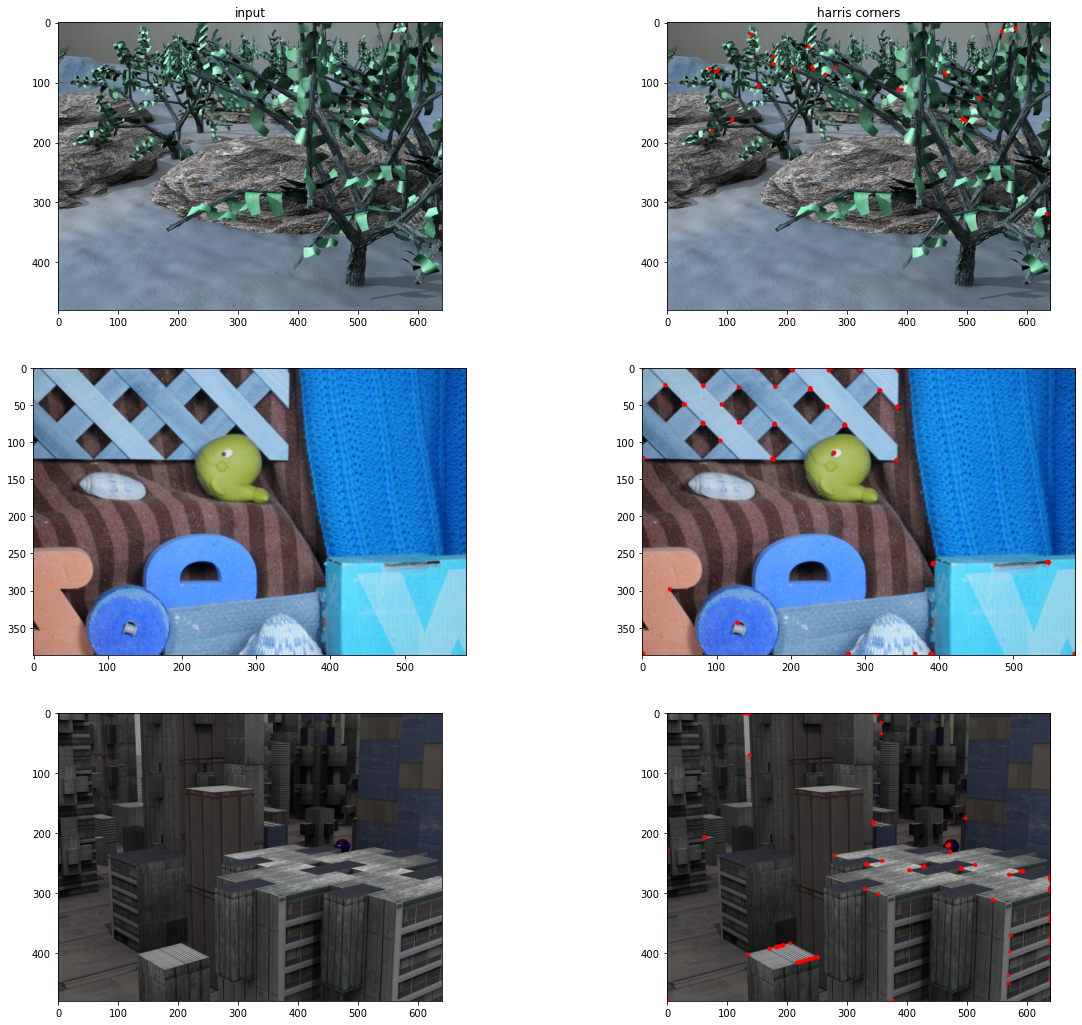

In [48]:
img = cv2.imread('data/all-frames-colour/Grove3/frame08.png')
img2 = cv2.imread('data/all-frames-colour/RubberWhale/frame10.png')
img3 = cv2.imread('data/all-frames-colour/Urban2/frame09.png')
img1_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img3_gray = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
corners = harris(img,0.5)
corners2 = harris(img2,0.4)
corners3 = harris(img3,0.48)

# display images
f, axarr = plt.subplots(3,2, figsize=(20,18))
axarr[0][0].imshow(img)
axarr[0][0].title.set_text('input')
axarr[0][1].imshow(corners)
axarr[0][1].title.set_text('harris corners',)
axarr[1][0].imshow(img2)
axarr[1][0].title.set_text('',)
axarr[1][1].imshow(corners2)
axarr[1][1].title.set_text('',)
axarr[2][0].imshow(img3)
axarr[2][0].title.set_text('',)
axarr[2][1].imshow(corners3)
axarr[2][1].title.set_text('',)


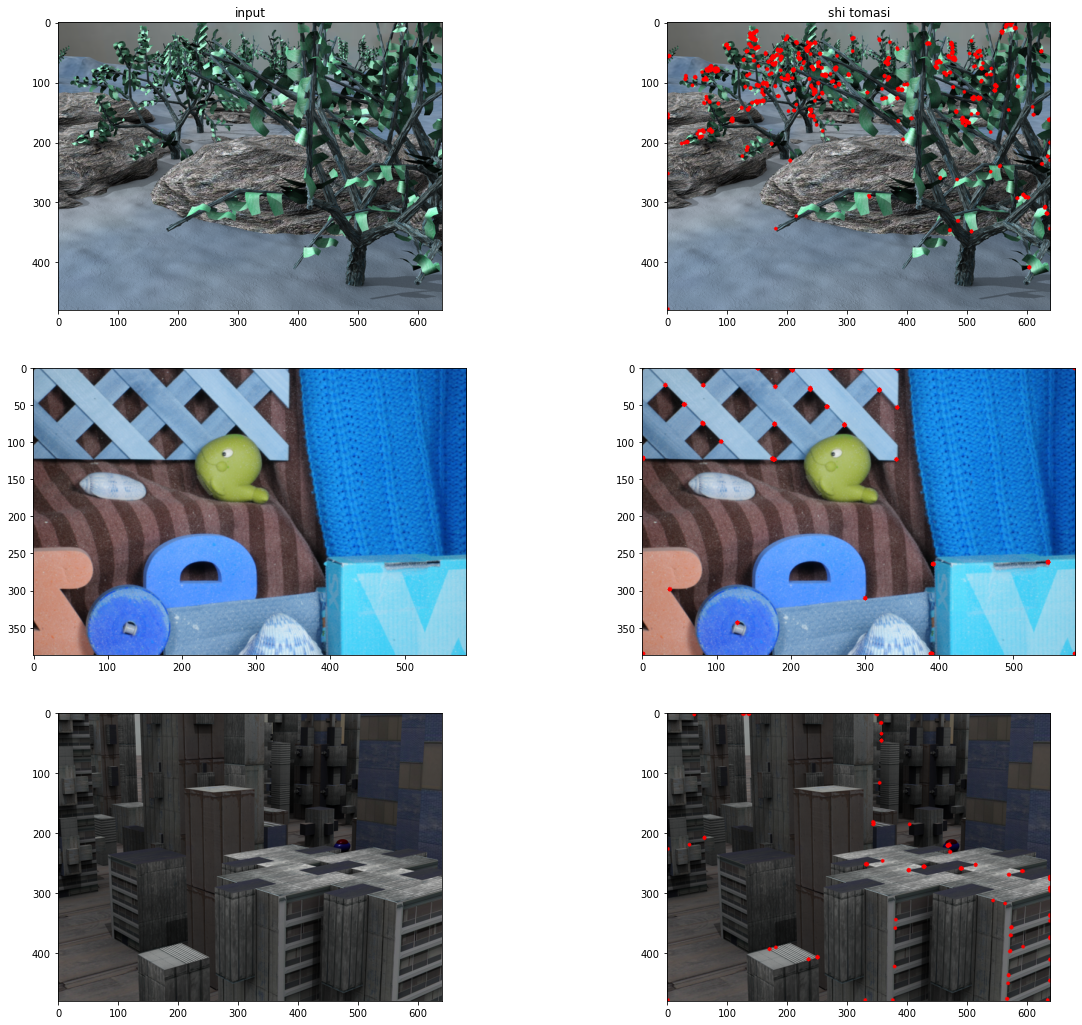

In [100]:


corners = Shi(img)

corners2 = Shi(img2)
corners3 = Shi(img3)
# display images
f, axarr = plt.subplots(3,2, figsize=(20,18))
axarr[0][0].imshow(img)
axarr[0][0].title.set_text('input')
axarr[0][1].imshow(corners)
axarr[0][1].title.set_text('shi tomasi',)
axarr[1][0].imshow(img2)
axarr[1][0].title.set_text('',)
axarr[1][1].imshow(corners2)
axarr[1][1].title.set_text('',)
axarr[2][0].imshow(img3)
axarr[2][0].title.set_text('',)
axarr[2][1].imshow(corners3)
axarr[2][1].title.set_text('',)


### 2.2  Forward-Additive Sparse Optical Flow (Lukas Kanade)

In [33]:
import os
from scipy import signal
cwd = os.getcwd() + '/data/all-frames-colour/Grove3/'
filter_x = np.transpose(np.array([[-1., -1.], [1., 1.]]) * 0.25)
filter_y = np.array([[-1., -1.], [1., 1.]]) * 0.25
filter_current = np.array([[-1., -1.], [-1., -1.]]) * 0.25
filter_next = np.array([[1., 1.], [1., 1.]]) * 0.25
frames = []
for image in os.listdir(cwd):
    path = cwd + image 
    img = cv2.imread(path)
    frames.append(img)
def LukasKanadeForwardAdditive(img1, img2, windowSize,t) :     
    img1 = cv2.GaussianBlur(img1, (3, 3), 0)
    img2 = cv2.GaussianBlur(img2, (3, 3), 0)
    img1 = img1[:,:,0]
    img2 = img2[:,:,0]
    fx1 = signal.convolve2d(img2, filter_x, mode='same')
    fx2 = signal.convolve2d(img2, filter_x, mode='same')
    fy1 = signal.convolve2d(img1, filter_y, mode='same')
    fy2 = signal.convolve2d(img2, filter_y, mode='same')
    ft = signal.convolve2d(img1, filter_current, mode='same') + \
         signal.convolve2d(img2, filter_next, mode='same')
    
    fx_sum = fx1 + fx2
    fy_sum = fy1 + fy2
    h, w = img1.shape
    
    u = np.zeros(img1.shape)
    v = np.zeros(img1.shape)

    # within a window of 3 times 3
    for i in range(1, h-1):
        for j in range(1, w-1):
            Ix = fx_sum[i-1: i+2, j-1: j+2].flatten()
            Iy = fy_sum[i-1: i+2, j-1: j+2].flatten()
            It = ft[i-1: i+2, j-1: j+2].flatten()
            b = np.reshape(It, (It.shape[0], 1)) 
            A = np.vstack((Ix, Iy)).T 

            # if the smallest eigenvalue of A'A is larger than the threshold t, it is moving:
            if np.min(abs(np.linalg.eigvals(np.matmul(A.T, A)))) >= t:
                nu = np.matmul(np.linalg.pinv(A), b)
                u[i,j] = nu[0]
                v[i,j] = nu[1]
    return fx_sum, fy_sum, ft, u, v


<Figure size 1440x1080 with 0 Axes>

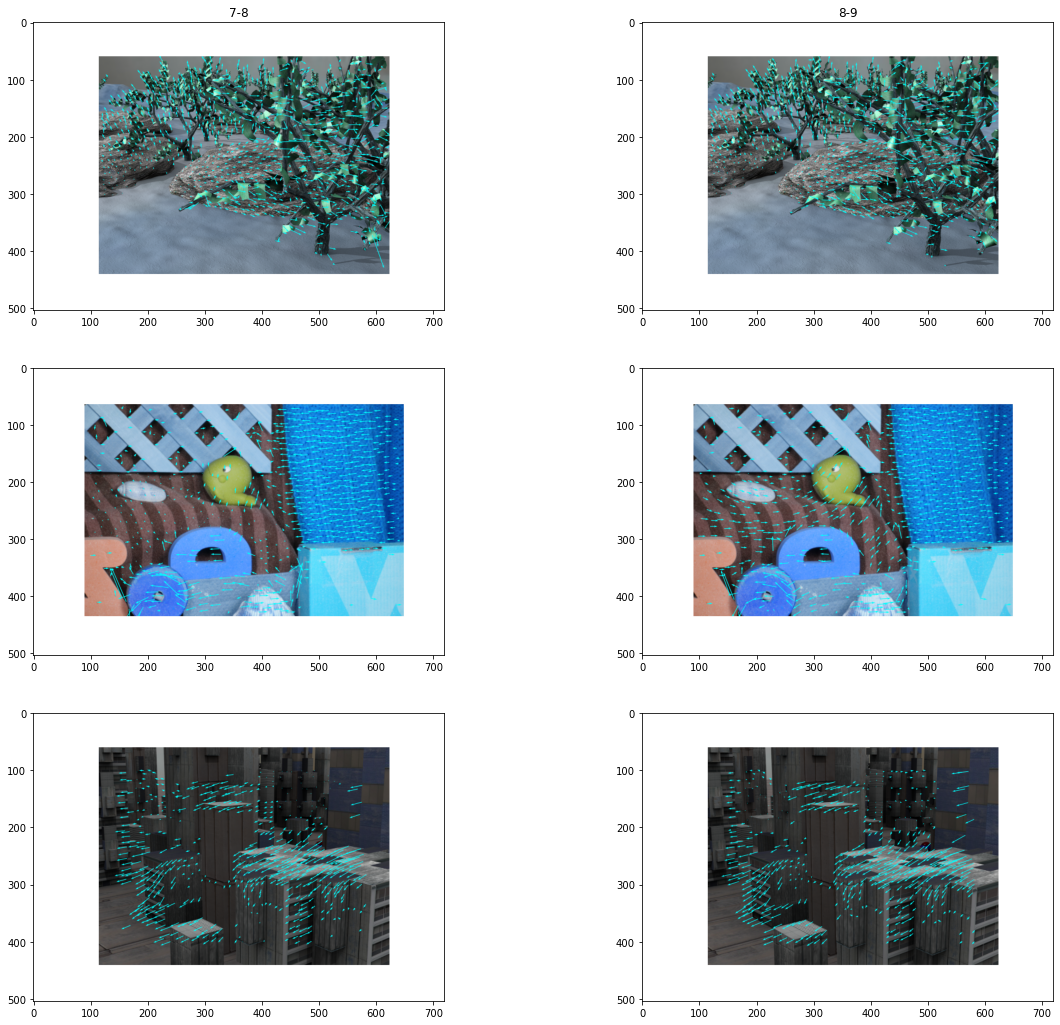

In [32]:
fig = plt.figure(figsize=(20, 15))
rows, cols =2, 4
flows = []
for i in range(7,9):
    
    img = frames[i]
    img2 = frames[i+1]
    im = LukasKanadeForwardAdditive(img,img2,3,0.01)

f, axarr = plt.subplots(3,2, figsize=(20,18))
axarr[0][0].imshow(im2)
axarr[0][0].title.set_text('7-8')
axarr[0][1].imshow(im3)
axarr[0][1].title.set_text('8-9',)
axarr[1][0].imshow(im4)
axarr[1][0].title.set_text('',)
axarr[1][1].imshow(im5)
axarr[1][1].title.set_text('',)
axarr[2][0].imshow(im6)
axarr[2][0].title.set_text('',)
axarr[2][1].imshow(im7)
axarr[2][1].title.set_text('',)

## 2.2  Analyzing Lucas-Kanade Method
### 1. 
This is because if $A^ T A$ has a rank less than 2, it is not invertible since it is not full
rank. This means that the Lucas-Kanade equation has no solution at these points.
The threshold $\tau$ is used on lower eigenvalues. Using τ ensures that the determinant
is not very small, since if a matrix has a determinant of zero, it is not invertible. This
means that solutions become less reliable as the determinant approaches zero.
### 2.
Using larger thresholds comes with a trade-off. When using a larger threshold,
only well-conditioned points like corners satisfy the threshold, and the flow estimation is best for these points. However, due to less number of points under
consideration, the overall flow estimation for the image becomes sparse.
### 3.
In general, I observed that results improved with an increase in window size. This
is particularly true for smoother sequences like RubberWhale. When using larger
windows, we have more equations to contain flow estimates for each point. The
trade-off is that we require more computational power since the computations
become more complicated and take longer, hence reducing the efficiency of the
algorithm. Smaller windows take less time, while larger windows give better results.
### 4 .

This method fails for rotations and occlusions. If the motion of the camera or
objects in the scene result in certain points, originally visible, being occluded in later
frames, this method fails since it requires the positions of the points in later frames to
estimate flow.
### 5 .
Ground truth visualizations are in HSV colour space. This is because the flow is
represented as a 2 × 1 vector. This means that it can be mapped to a point on a 2D
plane, specifically, the 2D colour wheel used in HSV colour representation (where,
for a given saturation, the angle determines the hue and magnitude determines the
value).